### 1.Import Modules

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantopian.pipeline import Pipeline 
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import CustomFactor,Returns,Latest,DailyReturns
from quantopian.pipeline.classifiers import Classifier
from quantopian.pipeline.filters import QTradableStocksUS,Q1500US
from quantopian.pipeline.classifiers.fundamentals import Sector
import itertools
from scipy.stats import skew
from quantopian.pipeline.factors import RSI

### 2.Custom Factor

In [8]:
class Skewness(CustomFactor):
    inputs = [Returns(window_length = 2 )]
    window_length = 22
    def compute(self, today, asset_ids, out, returns):
        out[:]=skew(returns)

### Object and Basic Logic

Our model is designed to catch the $midterm$  $mispricing$ stocks to make excess returns.

Our basic logic is that:
1. If a stock's midterm performance is extremely bad but its financial performance is very strong, this stock will be assigned a high score, because we think the poor performance momentum will not keep long

2. If a stock's midterm performance is extremely bad and its financial performance is very bad, this kind of stock will be assigned a low score

3. If a stock's midterm performance is extremy high and its financial performance is still good, this stock will be given a high score, because we hope this tendency can be consistent in a forward period

4. If a stock's midterm performance is extremy high but its financial performance is bad, this stock will be given a low score


### Backtesting Results Summary

For the purpose of finding the mid-term momentum with extreme tendency, we use the top 10% -20 %'s 30,60 or 90 days' return. 
We need to note with this extreme momentum factor, our model's return can be significantly higher than that without this momentum. The detailed difference will be given in other notebooks

Our best dreamed model result is that we can make significant alpha and strong cumulative returns within all the regimes given by the DA.

According to our backtesting result, we indeed can make significantly high return using our model, but because the available history stock data is limited to 01/01/2012 and the backtesting function is limited, we can only backtest our model in 3 momentum regimes, 3 neutral regimes, 1 value regimes. Accoring to our backtesting results, we have following conclusions

1. Our model can be a very strong model for long in Momentum Regimes
2. Our model can be a very strong model for short in Value Regimes (Notice:*Data is limited)
3. Our model's performance in value regimes is still undetermined. In one of value regimes, our model is very strong, but in other 2 value regimes, results are not significang

### Model Factors 

We use following model factors:
1. Midterm-Momentun Factor (+) Core Factor
2. Earning-Yield Factor(+) Core Factor
3. Linear-Return Factor(+) Effective Factor
4. BP-Ratio Factor(-) Effective Factor
5. Cap-Rank Factor(+) Effective Factor

### 3.Prepare Labels

In [9]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

###  3.Make Pipeline

In [10]:
def make_pipeline():
    
    
    midterm_Momentum = RSI(window_length = 90)
    bp_ratio = 1/Latest([Fundamentals.pb_ratio])
    sales_per_share = Latest([Fundamentals.sales_per_share])
    earning_yields = Latest([Fundamentals.earning_yield])
    market_cap = Latest([Fundamentals.market_cap])
    returns_filter = midterm_Momentum.percentile_between(0,20)|midterm_Momentum.percentile_between(80,100)
    
    universe = Q1500US()&returns_filter
    
    market_cap_rank = market_cap.rank(mask=universe)
    bp_rank = bp_ratio.rank(mask = universe)
    momentum_rank = midterm_Momentum.rank(mask = universe)
    #dps_growth_rank = dps_growth.rank(mask = universe)
    sales_per_share_rank = sales_per_share.rank(mask = universe)
    earning_yields_score = earning_yields#.rank(mask = universe)
    
    pipe = Pipeline(
        columns = {
            'cap':market_cap,
            'cap_score':market_cap_rank,
            'bp_ratio':bp_ratio,
            'bp_score':bp_rank,
            'mom_score' : momentum_rank,
            '3-month-return':midterm_Momentum,
            'sales_per_share_score' : sales_per_share_rank,
            'sale_per_share' : sales_per_share,
            'earning_yields_score' : earning_yields_score,
            'earning_yields':earning_yields,
            'sector':Sector(),
            'Skew22':Skewness(window_length = 22).rank(mask=universe),
            'Skew05':Skewness(window_length = 5).rank(mask=universe)
        },
        screen = universe
    )
    
    return pipe
    

### 4.Run Pipeline

In [11]:
pipe = make_pipeline()
results = run_pipeline(pipe,'2013-04-30','2015-07-31')

### 5.Clean Date
##### 5.1 Prepare Mean Scores and Standard Deviation of Scores for Normalization

###### 5.1.1 BP Score

In [12]:
avg_bp_score = results['bp_score'].groupby(level=0).mean()
std_bp_score = results['bp_score'].groupby(level=0).std()

###### 5.1.2 CAP Score

In [13]:
avg_cap_score = results['cap_score'].groupby(level=0).mean()
std_cap_score = results['cap_score'].groupby(level=0).std()

###### 5.1.3 Earning Score

In [14]:
avg_earning_score = results['earning_yields_score'].groupby(level=0).mean()
std_earning_score = results['earning_yields_score'].groupby(level=0).std()

###### 5.1.4 Sale Score

In [15]:
avg_sale_score = results['sales_per_share_score'].groupby(level = 0).mean()
std_sale_score = results['sales_per_share_score'].groupby(level = 0).std()

###### 5.1.5 Momentum Score

In [16]:
avg_mom_score = results['mom_score'].groupby(level = 0).mean()
std_mom_score = results['mom_score'].groupby(level = 0).std()

###### 5.1.6 Skewness Score

In [17]:
results['MTermSkewShift'] = results['Skew05'] / results['Skew22']
avg_MT_Shift = results['MTermSkewShift'].groupby(level = 0).mean()
std_MT_Shift = results['MTermSkewShift'].groupby(level = 0).std()

##### 5.2 Prepare Mean Scores and Standard Deviation of Scores Columns for Insertion

###### 5.2.1 Prepare New Datafram

In [18]:
data = results[['3-month-return']].set_index(results.index)
asset_list_sizes = [group[1].size for group in data.groupby(level = 0 )]

###### 5.2.2 Create Column for Normalized BP Score

In [19]:
data['BP_Score'] = results['bp_score']

Avg_BP_column = [[idx] * size for idx, size in zip(avg_bp_score,asset_list_sizes)]
data['Avg_BP_Score'] = list(itertools.chain(*Avg_BP_column))

Std_BP_column = [[idx] * size for idx, size in zip(std_bp_score,asset_list_sizes)]
data['Std_BP_Score'] = list(itertools.chain(*Std_BP_column))

data['Normal_BP_Score'] = (data['BP_Score']-data['Avg_BP_Score'])/data['Std_BP_Score']

###### 5.2.3 Create Column for Normalized Cap Score

In [20]:
data['Cap_Score'] = results['cap_score']

Avg_Cap_column = [[idx] * size for idx, size in zip(avg_cap_score,asset_list_sizes)]
data['Avg_Cap_Score'] = list(itertools.chain(*Avg_Cap_column))

Std_Cap_column = [[idx] * size for idx, size in zip(std_cap_score,asset_list_sizes)]
data['Std_BP_Score'] = list(itertools.chain(*Std_Cap_column))

data['Normal_CAP_Score'] = (data['Cap_Score']-data['Avg_Cap_Score'])/data['Std_BP_Score']

###### 5.2.4 Create Column for Normalized Yield Score

In [21]:
data['Earning_Score'] = results['earning_yields_score']

Avg_Earning_column = [[idx] * size for idx, size in zip(avg_earning_score,asset_list_sizes)]
data['Avg_Earning_Score'] = list(itertools.chain(*Avg_Earning_column))

Std_Earning_column = [[idx] * size for idx, size in zip(std_earning_score,asset_list_sizes)]
data['Std_Earning_Score'] = list(itertools.chain(*Std_Earning_column))

data['Normal_Earning_Score'] = (data['Earning_Score']-data['Avg_Earning_Score'])/data['Std_Earning_Score']

###### 5.2.5 Create Column for Normalized Sale Score

In [22]:
data['Sale_Score'] = results['sales_per_share_score']

Avg_Sale_column = [[idx] * size for idx, size in zip(avg_sale_score,asset_list_sizes)]
data['Avg_Sale_Score'] = list(itertools.chain(*Avg_Sale_column))

Std_Sale_column = [[idx] * size for idx, size in zip(std_sale_score,asset_list_sizes)]
data['Std_Sale_Score'] = list(itertools.chain(*Std_Sale_column))

data['Normal_Sale_Score'] = (data['Sale_Score']-data['Avg_Sale_Score'])/data['Std_Sale_Score']

###### 5.2.6 Create Column for Normalized Momentum Score

In [23]:
results.head()

3-month-return  Skew05  Skew22  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])         47.046209   467.0   547.0   
                          Equity(24 [AAPL])        42.312100   239.0   136.0   
                          Equity(88 [ACI])         40.464123   114.0   385.0   
                          Equity(114 [ADBE])       62.133891   242.0   280.0   
                          Equity(128 [ADM])        60.902524   210.0   165.0   

                                              bp_ratio  bp_score  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])    1.467136     577.0   
                          Equity(24 [AAPL])   0.325595     242.0   
                          Equity(88 [ACI])    2.396932     586.0   
                          Equity(114 [ADBE])  0.311604     218.0   
                          Equity(128 [ADM])   0.852733     510.0   

                                                       cap  cap_score  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])    9.110659e+09      444.0   
                          Equity(24 [AAPL])   4.161420e+11      591.0   
                          Equity(88 [ACI])    1.160711e+09       70.0   
                          Equity(114 [ADBE])  2.184175e+10      525.0   
                          Equity(128 [ADM])   2.222807e+10      526.0   

                                              earning_yields  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])            0.0268   
                          Equity(24 [AAPL])           0.0946   
                          Equity(88 [ACI])           -0.6577   
                          Equity(114 [ADBE])          0.0325   
                          Equity(128 [ADM])           0.0558   

                                              earning_yields_score  mom_score  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])                  0.0268      138.0   
                          Equity(24 [AAPL])                 0.0946       43.0   
                          Equity(88 [ACI])                 -0.6577       27.0   
                          Equity(114 [ADBE])                0.0325      316.0   
                          Equity(128 [ADM])                 0.0558      210.0   

                                              sale_per_share  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])           22.0260   
                          Equity(24 [AAPL])         173.9468   
                          Equity(88 [ACI])           19.6756   
                          Equity(114 [ADBE])          8.6533   
                          Equity(128 [ADM])         136.7961   

                                              sales_per_share_score  sector  \
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])                    321.0     101   
                          Equity(24 [AAPL])                   586.0     311   
                          Equity(88 [ACI])                    297.0     101   
                          Equity(114 [ADBE])                  171.0     311   
                          Equity(128 [ADM])                   578.0     205   

                                              MTermSkewShift  
2013-04-30 00:00:00+00:00 Equity(2 [ARNC])          0.853748  
                          Equity(24 [AAPL])         1.757353  
                          Equity(88 [ACI])          0.296104  
                          Equity(114 [ADBE])        0.864286  
                          Equity(128 [ADM])         1.272727

In [24]:
data['Mom_Score'] = results['mom_score']

Avg_Mom_column = [[idx] * size for idx, size in zip(avg_mom_score,asset_list_sizes)]
data['Avg_Mom_Score'] = list(itertools.chain(*Avg_Mom_column))

Std_Mom_column = [[idx] * size for idx, size in zip(std_mom_score,asset_list_sizes)]
data['Std_Mom_Score'] = list(itertools.chain(*Std_Mom_column))

data['Normal_Mom_Score'] = (data['Mom_Score']-data['Avg_Mom_Score'])/data['Std_Mom_Score']

###### 5.2.7 Create Column for Normalized Skewness

In [25]:
data['MT_Score'] = results['MTermSkewShift']

Avg_MT_column = [[idx] * size for idx, size in zip(avg_MT_Shift,asset_list_sizes)]
data['Avg_MT_Shift'] = list(itertools.chain(*Avg_MT_column))

Std_MT_column = [[idx] * size for idx, size in zip(std_MT_Shift,asset_list_sizes)]
data['Std_MT_Shift'] = list(itertools.chain(*Std_MT_column))

data['Normal_MT'] = (data['MT_Score']-data['Avg_MT_Shift'])/data['Std_MT_Shift']

In [26]:
data2 = results[['3-month-return']].set_index(results.index)
data2['Normal_BP'] = data['Normal_BP_Score']
data2['Normal_CAP'] = data['Normal_CAP_Score']
data2['Normal_Earning'] = data['Normal_Earning_Score']
data2['Normal_Sale'] = data['Normal_Sale_Score']
data2['Normal_Return'] = data['Normal_Mom_Score']
data2['Normal_Skewness'] = data['Normal_MT']

### 6.Factor Analysis

Dropped 8.6% entries from factor data: 8.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-128.805774,-3.615043,-15.200442,15.720220,15358,5.085127
2,-9.156336,-2.523529,-4.413652,1.101218,15095,4.998046
3,-4.829516,-1.841613,-2.875772,0.482164,15057,4.985464
4,-3.355190,-1.277116,-2.078674,0.315932,15108,5.002351
5,-2.493095,-0.834421,-1.469875,0.242116,15093,4.997384
6,-1.800393,-0.312847,-0.964318,0.227001,15034,4.977849
7,-1.300466,0.071187,-0.514282,0.217209,15045,4.981491
8,-0.880894,0.419692,-0.120764,0.200601,15126,5.008311
9,-0.562581,0.816817,0.228585,0.210209,15022,4.973876


Returns Analysis


,11D,22D,33D
Ann. alpha,0.118,0.140,0.145
beta,-0.308,-0.363,-0.347
Mean Period Wise Return Top Quantile (bps),12.330,17.967,15.748
Mean Period Wise Return Bottom Quantile (bps),-73.004,-85.868,-96.083
Mean Period Wise Spread (bps),85.335,107.362,116.909


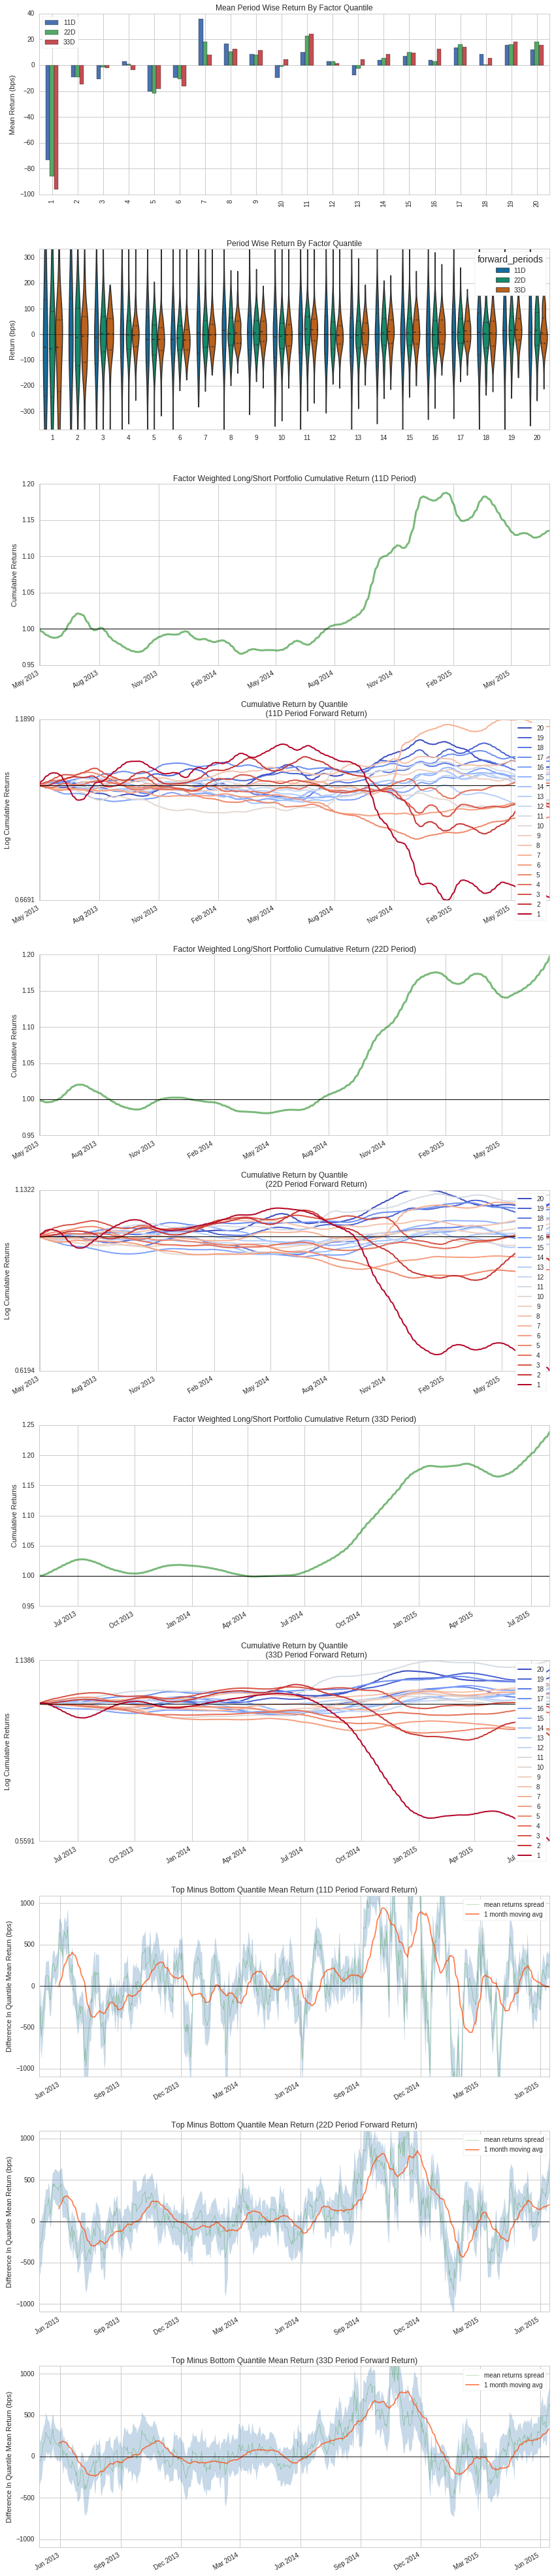

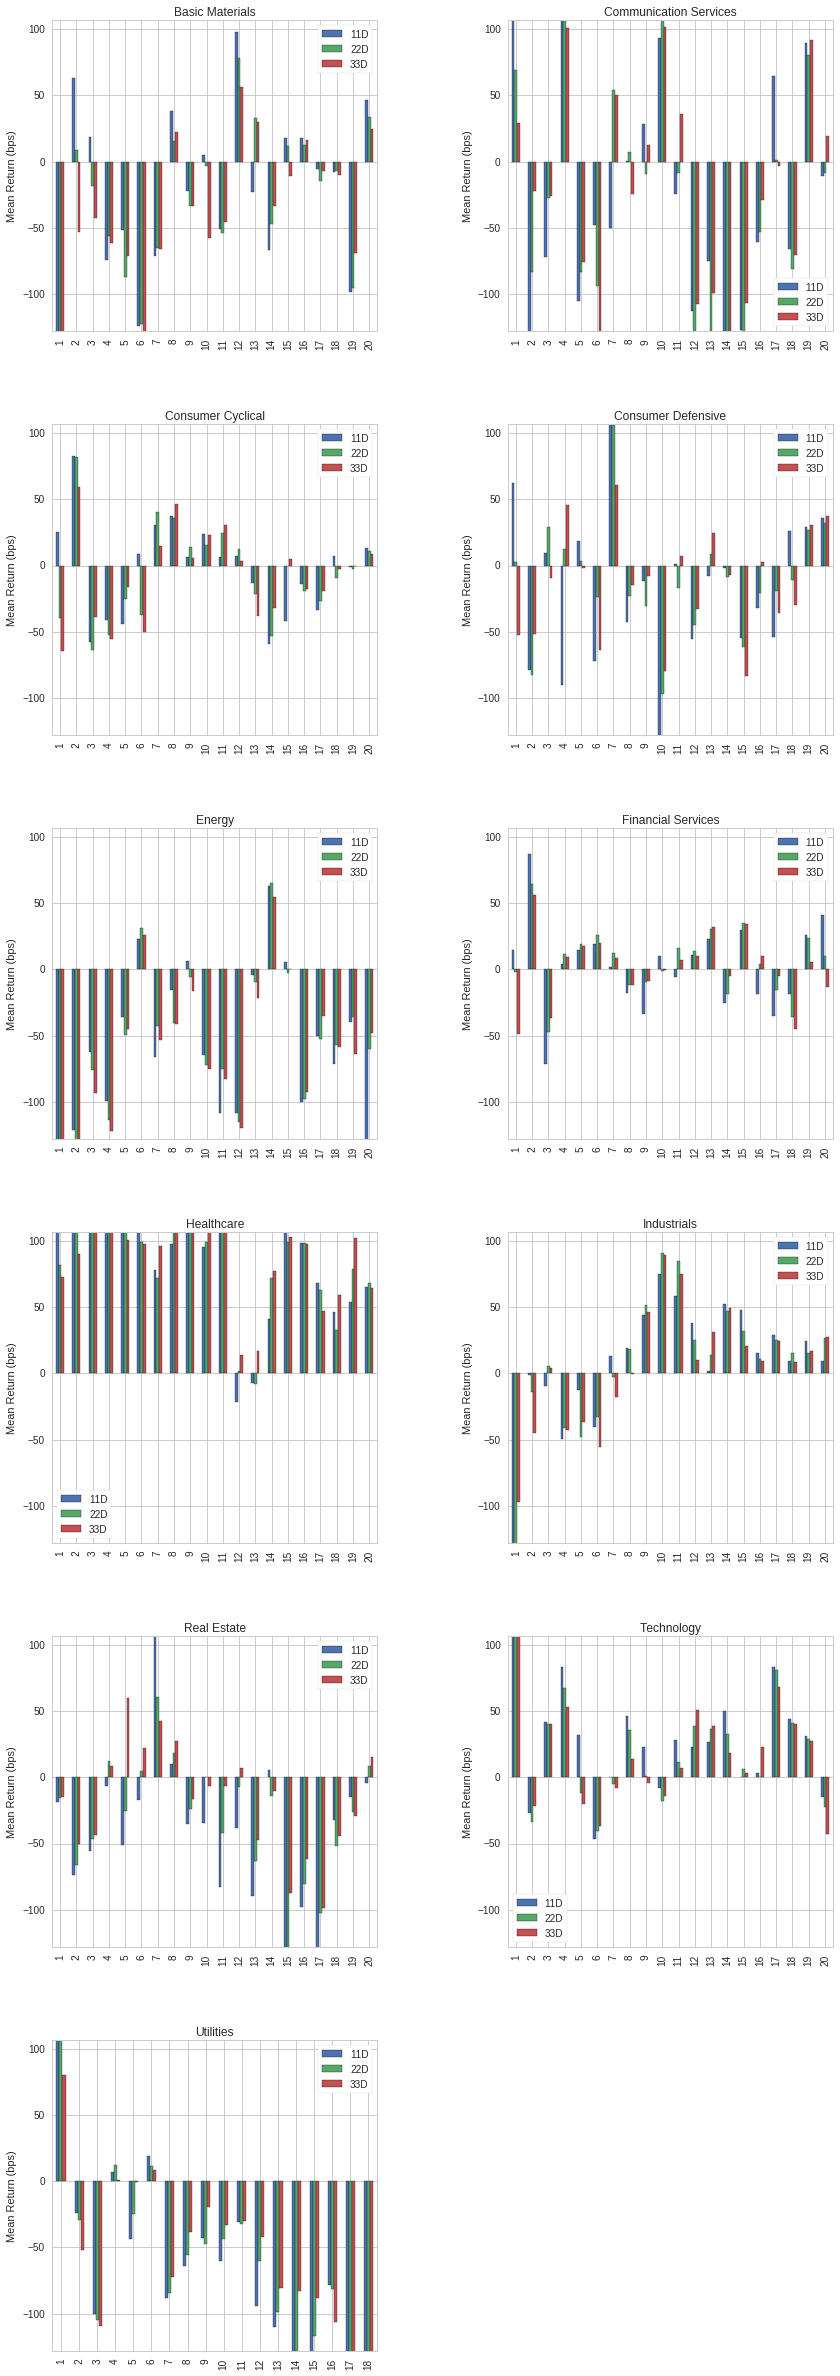

Information Analysis


,11D,22D,33D
IC Mean,0.029,0.038,0.048
IC Std.,0.106,0.101,0.101
Risk-Adjusted IC,0.269,0.375,0.470
t-stat(IC),6.237,8.687,10.878
p-value(IC),0.000,0.000,0.000
IC Skew,-0.053,0.207,-0.004
IC Kurtosis,0.643,-0.127,-0.421


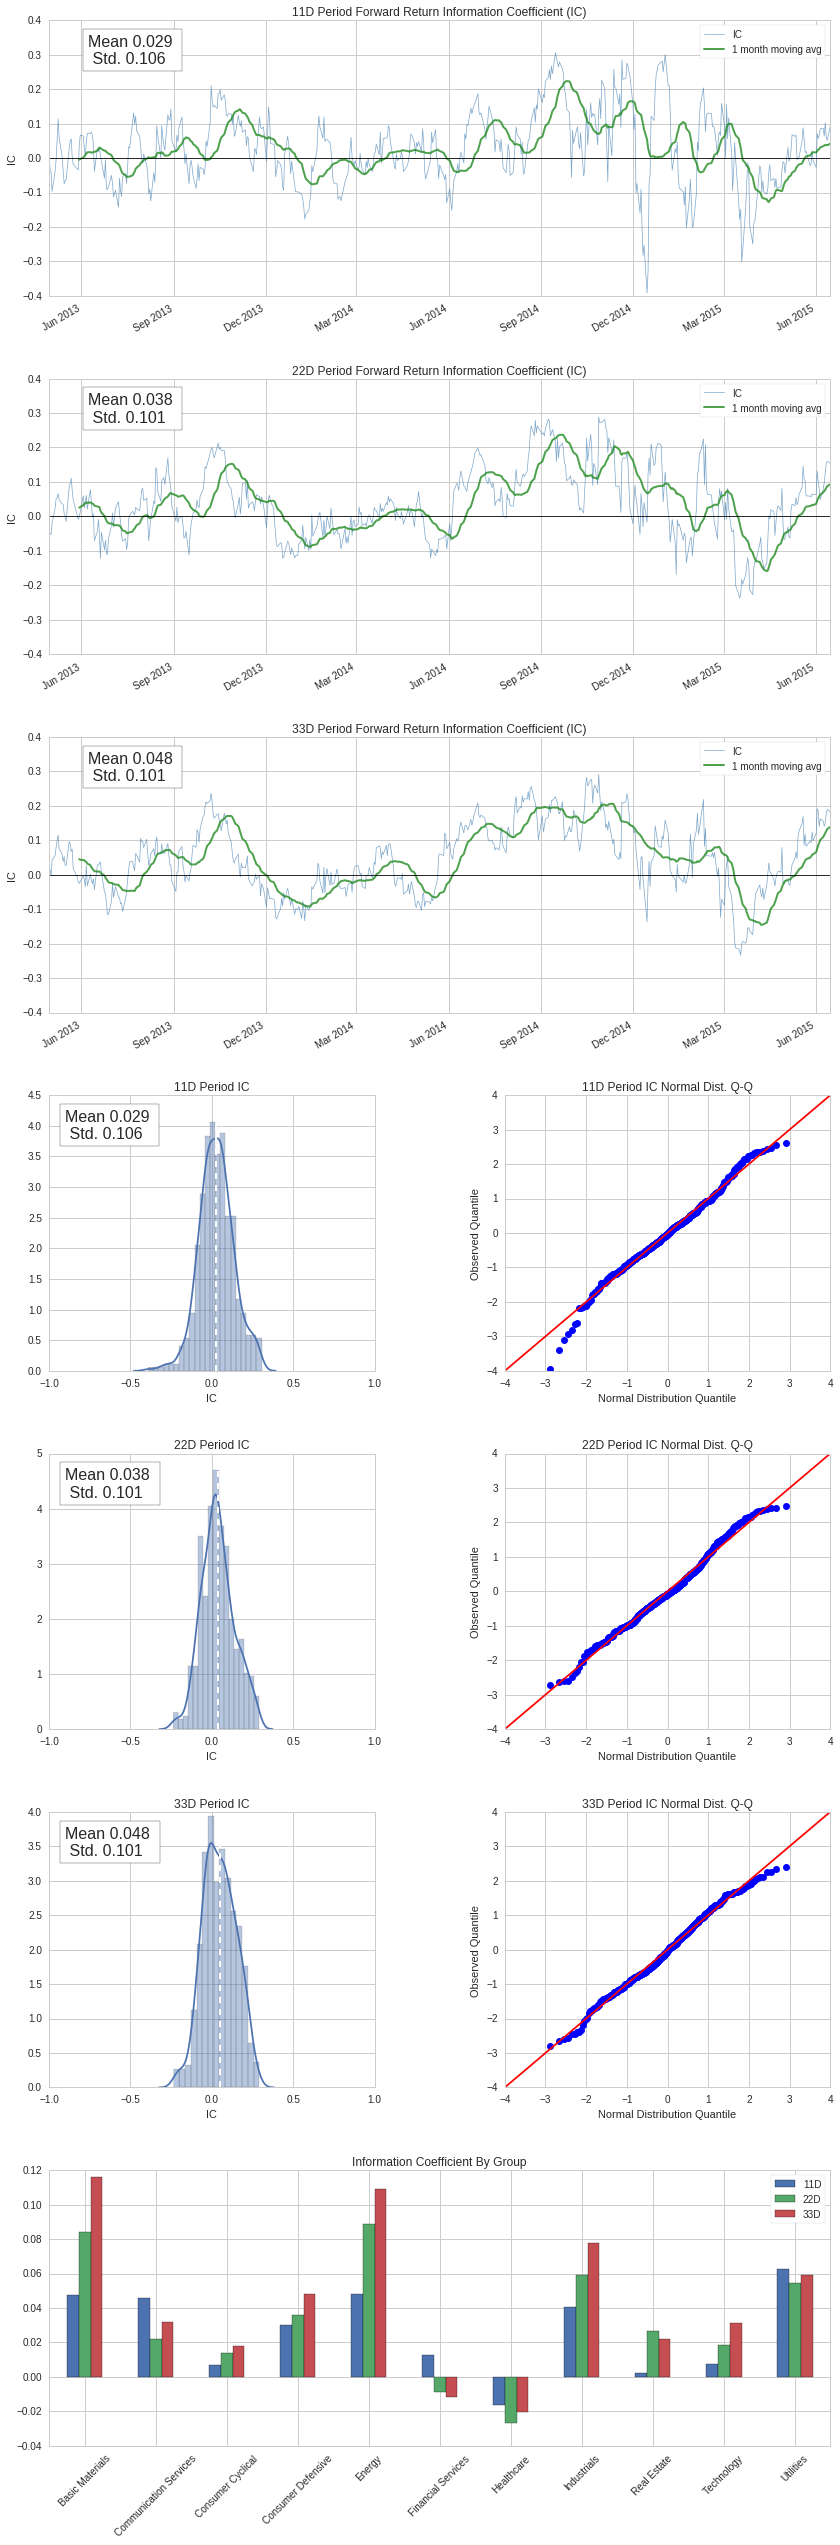

Turnover Analysis


,11D,22D,33D
Quantile 1 Mean Turnover,0.333,0.462,0.557
Quantile 2 Mean Turnover,0.484,0.625,0.717
Quantile 3 Mean Turnover,0.567,0.708,0.796
Quantile 4 Mean Turnover,0.618,0.748,0.827
Quantile 5 Mean Turnover,0.670,0.803,0.867
Quantile 6 Mean Turnover,0.666,0.793,0.856
Quantile 7 Mean Turnover,0.708,0.825,0.884
Quantile 8 Mean Turnover,0.726,0.846,0.889
Quantile 9 Mean Turnover,0.733,0.839,0.881
Quantile 10 Mean Turnover,0.739,0.848,0.895


,11D,22D,33D
Mean Factor Rank Autocorrelation,0.968,0.954,0.942


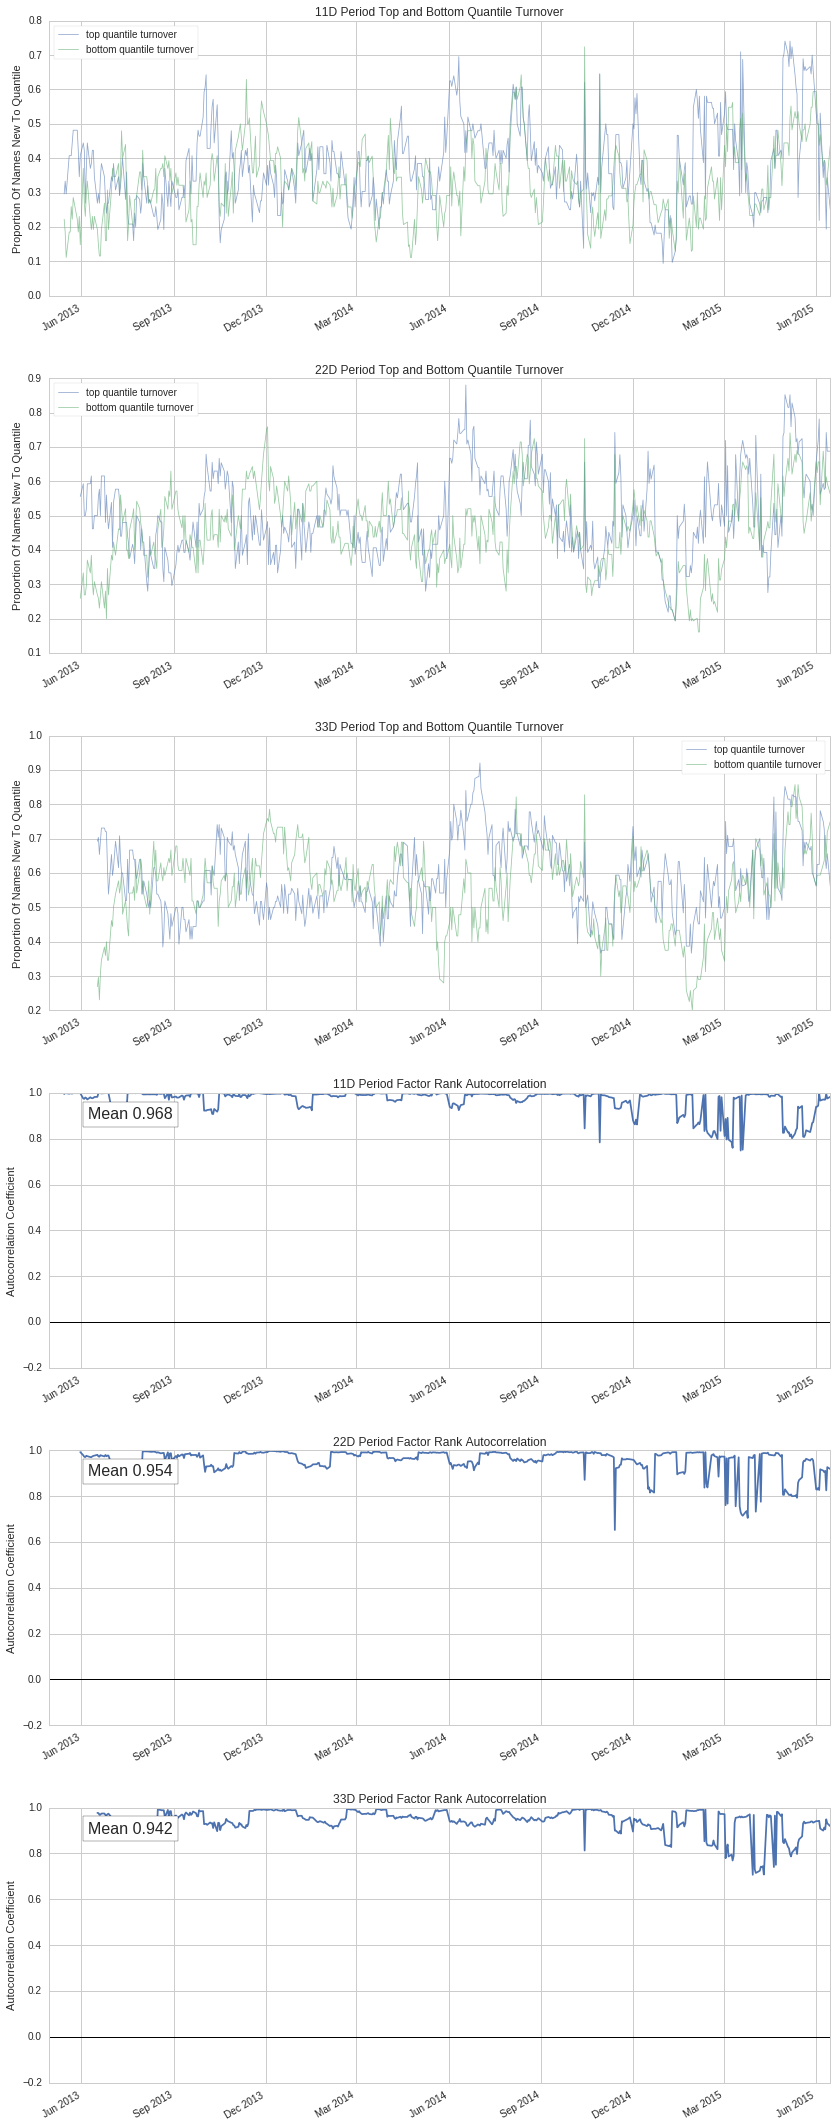

In [32]:
FACTOR =  0*data2['Normal_Sale'] + 5*data2['Normal_Earning']-2*data2['Normal_BP']+1*data2['Normal_CAP']
sectors = results['sector']
asset_list = results.index.levels[1]
prices = get_pricing(asset_list,start_date ='2013-04-30',end_date = '2015-07-31',fields = 'close_price')
period = (11,22,33)

import alphalens as al
factor_data =  al.utils.get_clean_factor_and_forward_returns(factor = FACTOR,
                                                           prices = prices,#Pass Price by DataFrame
                                                           groupby = sectors,#Group by Dictonary
                                                           groupby_labels = MORNINGSTAR_SECTOR_CODES,
                                                           periods = period,
                                                           quantiles = 20
                                                           )

al.tears.create_full_tear_sheet(factor_data,by_group = True)